# Predicting sentiment from product reviews


The goal of this first notebook is to explore logistic regression and feature engineering with existing Sklearn, Pandas, and Numpy functions.

In this notebook you will use product review data from Amazon.com to predict whether the sentiments about a product (from its reviews) are positive or negative.

* Do some feature engineering
* Train a logistic regression model to predict the sentiment of product reviews.
* Inspect the weights (coefficients) of a trained logistic regression model.
* Make a prediction (both class and probability) of sentiment for a new product review.
* Given the logistic regression weights, predictors and ground truth labels, write a function to compute the **accuracy** of the model.
* Inspect the coefficients of the logistic regression model and interpret their meanings.
* Compare multiple logistic regression models.

Let's get started!

In [1]:
import pandas as pd
import numpy as np

# Data preparation

We will use a dataset consisting of Amazon.com product reviews.

In [2]:
products = pd.read_csv('../datasets/Amazon Product Reviews I.csv')
np.unique(products['name'])

array(['Alexa Voice Remote for Amazon Echo and Echo Dot',
       'Alexa Voice Remote for Amazon Fire TV and Fire TV Stick',
       'All-New Amazon Fire 7 Tablet Case (7th Generation',
       'All-New Amazon Fire HD 8 Tablet Case (7th Generation',
       'All-New Amazon Fire TV Game Controller',
       'All-New Amazon Kid-Proof Case for Amazon Fire 7 Tablet (7th Generation',
       'All-New Amazon Kid-Proof Case for Amazon Fire HD 8 Tablet (7th Generation',
       'All-New Fire 7 Kids Edition Tablet',
       'All-New Fire 7 Tablet with Alexa',
       'All-New Fire HD 8 Kids Edition Tablet',
       'All-New Fire HD 8 Tablet with Alexa',
       'Amazon 5W USB Official OEM Charger and Power Adapter for Fire Tablets and Kindle eReaders',
       'Amazon Echo - Black',
       'Amazon Echo Dot Case (fits Echo Dot 2nd Generation only) - Charcoal Fabric',
       'Amazon Echo Dot Case (fits Echo Dot 2nd Generation only) - Indigo Fabric',
       'Amazon Echo Dot Case (fits Echo Dot 2nd Generation 

Now, let us see a preview of what the dataset looks like.

In [3]:
# Simplify relevant columns names
if('reviews.rating' in products.columns):
    products['rating']=products['reviews.rating']
    products.drop(['reviews.rating'],axis=1, inplace=True)

if('reviews.text' in products.columns):
    products['reviews']=products['reviews.text']
    products.drop(['reviews.text'],axis=1, inplace=True)
    
if('reviews.title' in products.columns):
    products['title']=products['reviews.title']
    products.drop(['reviews.title'],axis=1, inplace=True)

# Drop irrelevant columns
relevant_cols=['reviews','rating','title']
products = products.loc[:, relevant_cols]

# Drop Nana
products.dropna(subset=['rating', 'reviews','title'], inplace=True)
products.reset_index(drop=True, inplace=True)

print(products.head())

                                             reviews  rating  \
0  I initially had trouble deciding between the p...     5.0   
1  Allow me to preface this with a little history...     5.0   
2  I am enjoying it so far. Great for reading. Ha...     4.0   
3  I bought one of the first Paperwhites and have...     5.0   
4  I have to say upfront - I don't like coroporat...     5.0   

                                        title  
0              Paperwhite voyage, no regrets!  
1           One Simply Could Not Ask For More  
2  Great for those that just want an e-reader  
3                    Love / Hate relationship  
4                                   I LOVE IT  


## Build the word count vector for each review

Let us explore a specific example of a Amazon product.

In [4]:
print(products['reviews'][269])

I can read a lot longer without pain in my hands since the cover holds it for me. Very nice shade of blue.


Now, we will perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Transform the reviews into word-counts.

**Aside**. In this notebook, we remove all punctuations for the sake of simplicity. A smarter approach to punctuations would preserve phrases such as "I'd", "would've", "hadn't" and so forth. See [this page](https://neptune.ai/blog/tokenization-in-nlp) for an example of smart handling of punctuations.

In [5]:
import string 
def remove_punctuation(text):
    try: # python 2.x
        text = text.translate(None, string.punctuation) 
    except: # python 3.x
        translator = text.maketrans('', '', string.punctuation)
        text = text.translate(translator)
    return text

products['reviews'] = products['reviews'].apply(remove_punctuation)
print(products['reviews'])

0       I initially had trouble deciding between the p...
1       Allow me to preface this with a little history...
2       I am enjoying it so far Great for reading Had ...
3       I bought one of the first Paperwhites and have...
4       I have to say upfront  I dont like coroporate ...
                              ...                        
1172    This is not the same remote that I got for my ...
1173    I have had to change the batteries in this rem...
1174    Remote did not activate nor did it connect to ...
1175    It does the job but is super over priced I fee...
1176    I ordered this item to replace the one that no...
Name: reviews, Length: 1177, dtype: object


In [6]:
# Frequency counts
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(products['reviews'])
print(X_train_counts.shape)

# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf.shape)

word_count_df = pd.DataFrame(X_train_tfidf.toarray())
word_count_df = word_count_df.add_prefix('word_count_')
products = pd.concat([products, word_count_df], axis=1)

print(products.head())

(1177, 6750)
(1177, 6750)
                                             reviews  rating  \
0  I initially had trouble deciding between the p...     5.0   
1  Allow me to preface this with a little history...     5.0   
2  I am enjoying it so far Great for reading Had ...     4.0   
3  I bought one of the first Paperwhites and have...     5.0   
4  I have to say upfront  I dont like coroporate ...     5.0   

                                        title  word_count_0  word_count_1  \
0              Paperwhite voyage, no regrets!           0.0           0.0   
1           One Simply Could Not Ask For More           0.0           0.0   
2  Great for those that just want an e-reader           0.0           0.0   
3                    Love / Hate relationship           0.0           0.0   
4                                   I LOVE IT           0.0           0.0   

   word_count_2  word_count_3  word_count_4  word_count_5  word_count_6  ...  \
0           0.0           0.0           0.0   

Now, let us explore what the sample example above looks like after these 2 transformations. Here, each entry in the **word_count** column is a dictionary where the key is the word and the value is a count of the number of times the word occurs.

## Extract sentiments

We will **ignore** all reviews with *rating = 3*, since they tend to have a neutral sentiment.

In [7]:
products = products[products['rating'] != 3]
products.reset_index(drop=True, inplace=True)
products.shape

(1053, 6753)

Now, we will assign reviews with a rating of 4 or higher to be *positive* reviews, while the ones with rating of 2 or lower are *negative*. For the sentiment column, we use +1 for the positive class label and -1 for the negative class label.

In [8]:
products['sentiment'] = products['rating'].apply(lambda r : +1 if r > 3 else -1)
products.head()

,reviews,rating,title,word_count_0,word_count_1,word_count_2,word_count_3,word_count_4,word_count_5,word_count_6,...,word_count_6741,word_count_6742,word_count_6743,word_count_6744,word_count_6745,word_count_6746,word_count_6747,word_count_6748,word_count_6749,sentiment
0,I initially had trouble deciding between the p...,5.0,"Paperwhite voyage, no regrets!",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,Allow me to preface this with a little history...,5.0,One Simply Could Not Ask For More,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,I am enjoying it so far Great for reading Had ...,4.0,Great for those that just want an e-reader,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,I bought one of the first Paperwhites and have...,5.0,Love / Hate relationship,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,I have to say upfront I dont like coroporate ...,5.0,I LOVE IT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


array([[<AxesSubplot:title={'center':'sentiment'}>]], dtype=object)

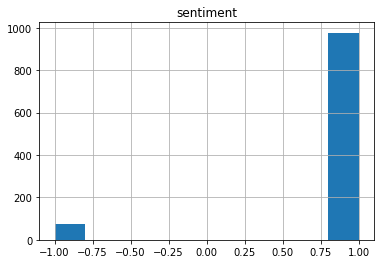

In [9]:
# View number of positive and negative sentiment
products.hist(column=['sentiment'])

Now, we can see that the dataset contains an extra column called **sentiment** which is either positive (+1) or negative (-1).

Note, there are significantly more positive reviews than negative reviews.

# Match number of positive and negative reviews

In [10]:
# Report number of positive examples
positive_sent = products[products['sentiment']==1]
print('There are {} positive reviews'.format(len(positive_sent)))

# Report number of negative examples
negative_sent = products[products['sentiment']==-1]
print('There are {} negative reviews'.format(len(negative_sent)))

# Sample number of negative example from positive examples (# positive > # negative)
positive_sample = positive_sent.sample(n = len(negative_sent))
print('[Update] There are {} positive reviews'.format(len(positive_sample)))

# Merge positive and negative examples and update products dataframe
frames = [negative_sent, positive_sample]
products = pd.concat(frames)
print(products.head())
print(products.tail())

There are 977 positive reviews
There are 76 negative reviews
[Update] There are 76 positive reviews
                                               reviews  rating  \
43   After 15 months my 500 tablet is no longer use...     1.0   
69   This is a great controller for our Fire TV I p...     2.0   
79   This is a great controller for our Fire TV I p...     2.0   
84   The connection drops out on this unit pretty b...     1.0   
117  As the Kids Edition is nothing more than a bas...     1.0   

                                                 title  word_count_0  \
43                                Dead after 15 months           0.0   
69   Great controller with 2 major problems! Not re...           0.0   
79   Great controller with 2 major problems! Not re...           0.0   
84   This needs to be way better for the amount I s...           0.0   
117          Freetime makes me angry. So, so angry. 3,           0.0   

     word_count_1  word_count_2  word_count_3  word_count_4  word_coun

## Split data into training and test sets

Let's perform a train/test split with 80% of the data in the training set and 20% of the data in the test set. We use `seed=1` so that everyone gets the same result.

In [11]:
from sklearn.model_selection import train_test_split

X, y = products.loc[:, ~products.columns.isin(['sentiment'])], products.loc[:, products.columns.isin(['sentiment'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
print(len(X_train))
print(len(y_train))

121
121


# Train a sentiment classifier with logistic regression

We will now use logistic regression to create a sentiment classifier on the training data. This model will use the column **word_count** as a feature and the column **sentiment** as the target. We will use `validation_set=None` to obtain same results as everyone else.

**Note:** This line may take 1-2 minutes.

In [12]:
X_train_sentiment = X_train.loc[:,X_train.columns.str.startswith('word_count_')]
X_test_sentiment = X_test.loc[:,X_test.columns.str.startswith('word_count_')]

X_train_sentiment.head()

,word_count_0,word_count_1,word_count_2,word_count_3,word_count_4,word_count_5,word_count_6,word_count_7,word_count_8,word_count_9,...,word_count_6740,word_count_6741,word_count_6742,word_count_6743,word_count_6744,word_count_6745,word_count_6746,word_count_6747,word_count_6748,word_count_6749
229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
from sklearn.linear_model import LogisticRegression
sentiment_model = LogisticRegression(random_state=0)
sentiment_model.fit(X_train_sentiment, np.ravel(y_train))

LogisticRegression(random_state=0)

**Aside**. You may get a warning to the effect of "Terminated due to numerical difficulties --- this model may not be ideal". It means that the quality metric (to be covered in Module 3) failed to improve in the last iteration of the run. The difficulty arises as the sentiment model puts too much weight on extremely rare words. A way to rectify this is to apply regularization, to be covered in Module 4. Regularization lessens the effect of extremely rare words. For the purpose of this assignment, however, please proceed with the model above.

Now that we have fitted the model, we can extract the weights (coefficients) as follows:

In [14]:
weights = sentiment_model.coef_
print(weights)

[[0. 0. 0. ... 0. 0. 0.]]


There are a total of `6750` coefficients in the model. Recall from the lecture that positive weights $w_j$ correspond to weights that cause positive sentiment, while negative weights correspond to negative sentiment. 

Fill in the following block of code to calculate how many *weights* are positive ( >= 0). (**Hint**: Use numpy to sum the weights and check *weights* must be positive ( >= 0)).

In [15]:
num_positive_weights = np.sum(weights >= 0)
num_negative_weights = np.sum(weights < 0)

print("Number of positive weights: %s " % num_positive_weights)
print("Number of negative weights: %s " % num_negative_weights)

Number of positive weights: 5675 
Number of negative weights: 1075 


**Discussion Question:** How many weights are >= 0?

## Making predictions with logistic regression

Now that a model is trained, we can make predictions on the **test data**. In this section, we will explore this in the context of 3 examples in the test dataset.  We refer to this set of 3 examples as the **sample_test_data**.

In [16]:
sample_test_data = X_test[10:13]
print(sample_test_data['rating'])
sample_test_data

804    4.0
384    4.0
840    5.0
Name: rating, dtype: float64


,reviews,rating,title,word_count_0,word_count_1,word_count_2,word_count_3,word_count_4,word_count_5,word_count_6,...,word_count_6740,word_count_6741,word_count_6742,word_count_6743,word_count_6744,word_count_6745,word_count_6746,word_count_6747,word_count_6748,word_count_6749
804,If you already have the Amazon Echo system the...,4.0,Handy speaker if you don't need the best sound.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
384,An Amazoncom official commented on this review...,4.0,"Decent, inexpensive, entry-level tablet 5,942 ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
840,We have bought two Taps one for ourselves and ...,5.0,Great for music,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's dig deeper into the first row of the **sample_test_data**. Here's the full review:

In [17]:
sample_test_data['reviews'].iloc[0]

'If you already have the Amazon Echo system then the Tap is a nice addition I use it primarily as an outdoor speaker for my patio when the weather is nice There are Bluetooth speakers on the market with better sound quality but it does an adequate job as a speaker The real advantage is being able to interface with the Echo system as well as item to music newsetc I have not used it off its charger long enough to comment on battery life but so far a six hour session outside was no problem'

That review seems pretty positive.

Now, let's see what the next row of the **sample_test_data** looks like. As we could guess from the sentiment (-1), the review is quite negative.

In [18]:
sample_test_data['reviews'].iloc[1]

'An Amazoncom official commented on this reviewWhats this The Amazon team saysOctober 11 2013Thank you for taking the time to share your feedback Were excited to see your encouraging comments regarding display and sound and appreciate the thoughtful analysis you did of this device compared to the previous generation Kindle Fire and Kindle Fire HD As you correctly point out the new Kindle Fire HD is the successor to last years entry level Kindle Fire which does not include features such as camera microphone or HDMI port You are also correct to point out that this device does not support Mayday although there are still multiple ways to get help for free directly from your device We hope you enjoy the new features and services Thanks The Kindle Team'

We will now make a **class** prediction for the **sample_test_data**. The `sentiment_model` should predict **+1** if the sentiment is positive and **-1** if the sentiment is negative. Recall from the lecture that the **score** (sometimes called **margin**) for the logistic regression model  is defined as:

$$
\mbox{score}_i = \mathbf{w}^T h(\mathbf{x}_i)
$$ 

where $h(\mathbf{x}_i)$ represents the features for example $i$.  We will write some code to obtain the **scores**. For each row, the **score** (or margin) is a number in the range **[-inf, inf]**.

In [19]:
scores = sample_test_data.loc[:, sample_test_data.columns.str.startswith('word_count_')].to_numpy() @ weights.reshape((-1)) + sentiment_model.intercept_
print(scores)

[ 0.18001181  0.0690312  -0.00620248]


### Predicting sentiment

These scores can be used to make class predictions as follows:

$$
\hat{y} = 
\left\{
\begin{array}{ll}
      +1 & \mathbf{w}^T h(\mathbf{x}_i) > 0 \\
      -1 & \mathbf{w}^T h(\mathbf{x}_i) \leq 0 \\
\end{array} 
\right.
$$

Using scores, write code to calculate $\hat{y}$, the class predictions:

In [20]:
y_pred = np.where(scores > 0, 1, -1)
print(y_pred)

[ 1  1 -1]


Run the following code to verify that the class predictions obtained by your calculations are the same as that obtained above.

In [21]:
print("Class predictions:")
print(sentiment_model.predict(
    sample_test_data.loc[:, sample_test_data.columns.str.startswith('word_count_')]))

Class predictions:
[ 1  1 -1]


**Checkpoint**: Make sure your class predictions match with the one obtained from above.

### Probability predictions

Recall from the lectures that we can also calculate the probability predictions from the scores using:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))}.
$$

Using the variable **scores** calculated previously, write code to calculate the probability that a sentiment is positive using the above formula. For each row, the probabilities should be a number in the range **[0, 1]**.

In [22]:
y_prob = 1 / (1 + np.exp(-scores))
print(y_prob)

[0.54488182 0.51725095 0.49844939]


**Checkpoint**: Make sure your probability predictions match the ones obtained from sklearn.

In [23]:
print("Class predictions for y=1:")
print(sentiment_model.predict_proba(
    sample_test_data.loc[:, sample_test_data.columns.str.startswith('word_count_')])[:, 1])

Class predictions for y=1:
[0.54488182 0.51725095 0.49844939]


** Discussion Question:** Of the three data points in **sample_test_data**, which one (first, second, or third) has the **lowest probability** of being classified as a positive review?

# Find the most positive (and negative) review

We now turn to examining the full test dataset, **test_data**, and use Numpy argsort to form predictions on all of the test data points for faster performance.

Using the `sentiment_model`, find the 20 reviews in the entire **test_data** with the **highest probability** of being classified as a **positive review**. We refer to these as the "most positive reviews."

To calculate these top-20 reviews, use the following steps:
1.  Make probability predictions on **test_data** using the `sentiment_model`. (**Hint:** When you call `.predict` to make predictions on the test data.)
2.  Sort the data according to those predictions and pick the top 20. (**Hint:** You can use indexing [-topn:] to find the top k rows sorted according to the value of a specified column.)

In [24]:
# Calculate the class probabilities for the test set
y_prob = sentiment_model.predict_proba(X_test_sentiment)

# Sort the test set in descending order of their probabilities of being positive
idx = np.argsort(-y_prob[:, 1])

# Get the indices of the 20 most positive reviews
idx_most_positive = idx[-20:] 
print(idx_most_positive)

# Get the corresponding reviews from the test set
most_positive_reviews = X_test.iloc[idx_most_positive]
print(most_positive_reviews)

[11 22 17 16  4 12 15 27 23 26 25  7  8  3 30  9 14  2 28  0]
                                                reviews  rating  \
384   An Amazoncom official commented on this review...     4.0   
96    I am writing this from the perspective of bein...     4.0   
500   Same features as Echo now but easier to move a...     5.0   
217                                                 Too     2.0   
469   Just really thought it would have been more us...     2.0   
840   We have bought two Taps one for ourselves and ...     5.0   
158   Love the new Kindle Priced right with an extra...     5.0   
842   I was not overly impressed with this system I ...     2.0   
39    I am updating my review from two months ago My...     4.0   
267   In this day and age of rectangles with screens...     2.0   
776   hard to use and does not support Guam online i...     1.0   
213                                     very overpriced     2.0   
968   As good as the Echo is the Echo Voice Remote s...     2.0   


**Discussion Question**: Which of the following products are represented in the 20 most positive reviews? [multiple choice]


Now, let us repeat this exercise to find the "most negative reviews." Use the prediction probabilities to find the  20 reviews in the **test_data** with the **lowest probability** of being classified as a **positive review**. Repeat the same steps above but make sure you **sort in the opposite order**.

In [25]:
# Get the indices of the 20 most negative reviews
idx_most_negative = idx[:20]

# Get the corresponding reviews from the test set
most_negative_reviews = X_test.iloc[idx_most_negative]
print(most_negative_reviews)

                                               reviews  rating  \
746  This is a great addition to my expanding smart...     5.0   
422  To sum up what I will tell you about in the de...     4.0   
597  Hi Everyone Alexa is the best of the best I fe...     5.0   
465  I have the Amazon dot which is great But after...     5.0   
433  This is the middle model of the three models t...     5.0   
582  Overall sound is not as good as Echo my primar...     4.0   
571  It is a great addition to my home office My Al...     5.0   
512  Love the Dot Hate the Tap Portable This device...     2.0   
403  So I dont normally write reviews but I just ha...     5.0   
804  If you already have the Amazon Echo system the...     4.0   
382  An Amazoncom official commented on this review...     4.0   
384  An Amazoncom official commented on this review...     4.0   
96   I am writing this from the perspective of bein...     4.0   
500  Same features as Echo now but easier to move a...     5.0   
217       

**Question**: Which of the following products are represented in the 20 most negative reviews?

## Compute accuracy of the classifier

We will now evaluate the accuracy of the trained classifier. Recall that the accuracy is given by


$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

This can be computed as follows:

* **Step 1:** Use the trained model to compute class predictions (**Hint:** Use the `predict` method)
* **Step 2:** Count the number of data points when the predicted class labels match the ground truth labels (called `true_labels` below).
* **Step 3:** Divide the total number of correct predictions by the total number of data points in the dataset.

Complete the function below to compute the classification accuracy:

In [26]:
def get_classification_accuracy(model, data, true_labels):
    # First get the predictions
    ## YOUR CODE HERE
    pred = model.predict(data)
    
    # Compute the number of correctly classified examples
    ## YOUR CODE HERE
    num_correct = np.sum(pred == true_labels.to_numpy().reshape(-1))

    # Then compute accuracy by dividing num_correct by total number of examples
    ## YOUR CODE HERE
    accuracy = num_correct / len(data)
    
    return accuracy

Now, let's compute the classification accuracy of the **sentiment_model** on the **test_data**.

In [27]:
get_classification_accuracy(sentiment_model, X_test_sentiment, y_test)

0.7741935483870968

**Discussion Question**: What is the accuracy of the **sentiment_model** on the **test_data**? Round your answer to 2 decimal places (e.g. 0.76).

**Discussion Question**: Does a higher accuracy value on the **training_data** always imply that the classifier is better?

## Learn another classifier with fewer words

There were a lot of words in the model we trained above. We will now train a simpler logistic regression model using only a subset of words that occur in the reviews. For this assignment, we selected a 20 words to work with. These are:

In [28]:
significant_words = ['love', 'great', 'easy', 'old', 'amazing', 'perfect', 'loves', 
      'well', 'able', 'car', 'broke', 'less', 'even', 'waste', 'disappointed', 
      'work', 'product', 'money', 'would', 'return']

In [29]:
len(significant_words)

20

In [30]:
#all_words = count_vect.get_feature_names_out() # newer version of sklearn
all_words = count_vect.get_feature_names()

For each review, we will use the **word_count** column and trim out all words that are **not** in the **significant_words** list above. We will use the [SArray dictionary trim by keys functionality]( https://dato.com/products/create/docs/generated/graphlab.SArray.dict_trim_by_keys.html). Note that we are performing this on both the training and test set.

In [31]:
# Extract significant words and split train/test sets

sig_word_set = set(significant_words)
sig_idx = [i for i, e in enumerate(all_words) if e in sig_word_set]

X_train_sig = X_train_sentiment.iloc[:, sig_idx]
X_test_sig = X_test_sentiment.iloc[:, sig_idx]

X_train_sig.head()

,word_count_310,word_count_515,word_count_1016,word_count_1137,word_count_1838,word_count_2039,word_count_2192,word_count_2764,word_count_3522,word_count_3662,word_count_3666,word_count_3901,word_count_4164,word_count_4416,word_count_4680,word_count_5069,word_count_6489,word_count_6538,word_count_6648,word_count_6671
229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.108244,0.0,0.000000,0.000000,0.0,0.155978,0.0,0.0,0.000000
543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.149315,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.045696,0.0,0.0,0.000000,0.0,0.041285,0.032184,0.0,0.000000,0.0,0.0,0.056221
457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000


Let's see what the first example of the dataset looks like:

In [32]:
X_train['reviews'].iloc[0]

'I typically dont post reviews however dont waste your money on this case I got it on Friday and started using it that evening Its now Thursday and the case is peeling at the edges the fabric around the camera hole has started bubbling and the felt on the inside edge is wearing off i have not had any issues with it standing on its own like other people have mentioned I am giving this a two star mainly because it is still functional I am tempted to send it back but I like the functionality of this case'

The **word_count** column had been working with before looks like the following:

In [33]:
X_train_sentiment.iloc[0, :]

word_count_0       0.0
word_count_1       0.0
word_count_2       0.0
word_count_3       0.0
word_count_4       0.0
                  ... 
word_count_6745    0.0
word_count_6746    0.0
word_count_6747    0.0
word_count_6748    0.0
word_count_6749    0.0
Name: 229, Length: 6750, dtype: float64

Since we are only working with a subset of these words, the column **word_count_subset** is a subset of the above dictionary. In this example, only 2 `significant words` are present in this review.

In [34]:
X_train_sig.iloc[0, :]

word_count_310     0.000000
word_count_515     0.000000
word_count_1016    0.000000
word_count_1137    0.000000
word_count_1838    0.000000
word_count_2039    0.000000
word_count_2192    0.000000
word_count_2764    0.000000
word_count_3522    0.000000
word_count_3662    0.000000
word_count_3666    0.000000
word_count_3901    0.108244
word_count_4164    0.000000
word_count_4416    0.000000
word_count_4680    0.000000
word_count_5069    0.000000
word_count_6489    0.155978
word_count_6538    0.000000
word_count_6648    0.000000
word_count_6671    0.000000
Name: 229, dtype: float64

## Train a logistic regression model on a subset of data

We will now build a classifier with **word_count_subset** as the feature and **sentiment** as the target. 

In [35]:
simple_model = LogisticRegression(random_state=0)
simple_model.fit(X_train_sig, np.ravel(y_train))

print(simple_model)

LogisticRegression(random_state=0)


We can compute the classification accuracy using the `get_classification_accuracy` function you implemented earlier.

In [36]:
get_classification_accuracy(simple_model, X_test_sig, y_test)

0.5806451612903226

Now, we will inspect the weights (coefficients) of the **simple_model**:

In [37]:
print(simple_model.coef_)

[[-0.10478966  0.13355858  0.          0.03031667 -0.19878492  0.45147947
  -0.07119773  1.02081719 -0.04144197  0.61359567  0.29898731 -0.22158574
   0.16055619  0.0930607   0.15536263 -0.22411594 -0.425665    0.00498569
  -0.28874078 -0.14998954]]


Let's sort the coefficients (in descending order) by the **value** to obtain the coefficients with the most positive effect on the sentiment.

In [38]:
print(-np.sort(-simple_model.coef_, ))

[[ 1.02081719  0.61359567  0.45147947  0.29898731  0.16055619  0.15536263
   0.13355858  0.0930607   0.03031667  0.00498569  0.         -0.04144197
  -0.07119773 -0.10478966 -0.14998954 -0.19878492 -0.22158574 -0.22411594
  -0.28874078 -0.425665  ]]


**Discussion Question**: Consider the coefficients of **simple_model**. There should be 21 of them, an intercept term + one for each word in **significant_words**. How many of the 20 coefficients (corresponding to the 20 **significant_words** and *excluding the intercept term*) are positive for the `simple_model`?

In [39]:
num_positive_weights = np.sum(simple_model.coef_ >= 0)
print(num_positive_weights)

11


**Discussion Question**: Are the positive words in the **simple_model** (let us call them `positive_significant_words`) also positive words in the **sentiment_model**?

# Comparing models

We will now compare the accuracy of the **sentiment_model** and the **simple_model** using the `get_classification_accuracy` method you implemented above.

First, compute the classification accuracy of the **sentiment_model** on the **train_data**:

In [40]:
sentiment_model_train_acc = get_classification_accuracy(sentiment_model, X_train_sentiment, y_train)
print(sentiment_model_train_acc)

0.9917355371900827


Now, compute the classification accuracy of the **simple_model** on the **train_data**:

In [41]:
simple_model_test_acc = get_classification_accuracy(simple_model, X_train_sig, y_train)
print(simple_model_test_acc)

0.6694214876033058


**Discussion Question**: Which model (**sentiment_model** or **simple_model**) has higher accuracy on the TRAINING set?

Now, we will repeat this exercise on the **test_data**. Start by computing the classification accuracy of the **sentiment_model** on the **test_data**:

In [42]:
sentiment_model_test_acc = get_classification_accuracy(sentiment_model, X_test_sentiment, y_test)
print(sentiment_model_test_acc)

0.7741935483870968


Next, we will compute the classification accuracy of the **simple_model** on the **test_data**:

In [43]:
simple_model_test_acc = get_classification_accuracy(simple_model, X_test_sig, y_test)
simple_model_test_acc

0.5806451612903226

**Discussion Question**: Which model (**sentiment_model** or **simple_model**) has higher accuracy on the TEST set?

**Discussion Question**: Comment out the sention on 'Match number of positive and negative reviews' and re-run the notebook. Which model (**sentiment_model** or **simple_model**) has higher accuracy on the TEST set? 

## Baseline: Majority class prediction

It is quite common to use the **majority class classifier** as the a baseline (or reference) model for comparison with your classifier model. The majority classifier model predicts the majority class for all data points. At the very least, you should healthily beat the majority class classifier, otherwise, the model is (usually) pointless.

What is the majority class in the **train_data**?

In [44]:
num_positive = int(np.sum(y_train == +1))
num_negative = int(np.sum(y_train == -1))
print(num_positive)
print(num_negative)

59
62


Now compute the accuracy of the majority class classifier on **test_data**.

**Discussion Question**: Enter the accuracy of the majority class classifier model on the **test_data**. Round your answer to two decimal places (e.g. 0.76).

In [45]:
if num_positive >= num_negative:
    y_pred = 1
else:
    y_pred = -1

n_correct = np.sum(y_test == y_pred)
accuracy = n_correct / len(X_test)
print(accuracy)

sentiment    0.451613
dtype: float64


**Discussion Question**: Is the **sentiment_model** definitely better than the majority class classifier (the baseline)?

# Training Logistic Regression via Stochastic Gradient Descent

The goal of this notebook is to implement a logistic regression classifier using stochastic gradient descent. 

Define hyperparameters for training

In [46]:
max_iter=1000           # number of passes on training data
tol=1e-3                # stopping criteria for iterations
penalty='l2'            # 'l1' and 'l2' regularization term
alpha=0.001             # Constant that multiplies the regularization term. Ranges from [0 Inf)
loss='log'              # 'log' is logistic regression, 'hinge' for Support Vector Machine
random_state=42         # seed of the pseudo random number generated which is used while shuffling the data

Create SGD model using Sklearn

In [47]:
from sklearn.linear_model import SGDClassifier

# Create SGD model
sgd_model = SGDClassifier(max_iter=max_iter, 
                  tol=tol,
                  penalty=penalty,
                  alpha=alpha,
                  loss=loss,
                  random_state=random_state)
sgd_model.fit(X_train_sentiment, np.ravel(y_train))

SGDClassifier(alpha=0.001, loss='log', random_state=42)

Evalaute the SGD model on the sentiment test set

In [48]:
sentiment_predictions = sgd_model.predict(X_test_sentiment.loc[:, X_test_sentiment.columns.str.startswith('word_count_')])
sentiment_predictions

array([-1,  1, -1, -1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1, -1,  1, -1, -1,  1, -1,  1, -1])

Inspect SGD coefficients

In [49]:
sgd_model.coef_

array([[0., 0., 0., ..., 0., 0., 0.]])

# Stochastic Gradient Descent with Cross Validation

In [50]:
# Stochastic Gradient Descent with Cross Validation
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score, cross_validate

# evaluation method
n_splits=4
n_repeats=5
sgd_cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)

# define model
sgd_model = SGDClassifier(max_iter=max_iter, 
                              tol=tol,
                              penalty=penalty,
                              alpha=alpha,
                              loss=loss,
                              random_state=random_state)

Evaluate cross validation scores

In [51]:
sgd_results = cross_validate(sgd_model, X_train_sentiment, np.ravel(y_train), scoring='accuracy',cv=sgd_cv, n_jobs=-1, return_estimator=True)

best_model_idx = np.argmin(sgd_results['test_score'])
estimator = sgd_results['estimator'][best_model_idx]
print(estimator.coef_)

[[0. 0. 0. ... 0. 0. 0.]]


In [52]:
# force scores to be positive
scores = abs(sgd_results['test_score'])
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.742 (0.069)


**Discussion Question** Explore effects of L2 regularization

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

## Confusion Matrix

The accuracy, while convenient, does not tell the whole story. For a fuller picture, we turn to the **confusion matrix**. In the case of binary classification, the confusion matrix is a 2-by-2 matrix laying out correct and incorrect predictions made in each label as follows:
```
              +---------------------------------------------+
              |                Predicted label              |
              +----------------------+----------------------+
              |          (-1)        |         (+1)         |
+-------+-----+----------------------+----------------------+
| True  |(-1) | # of true negative  | # of false positive |
| label +-----+----------------------+----------------------+
|       |(+1) | # of false negative | # of true positive  |
+-------+-----+----------------------+----------------------+
```
To print out the confusion matrix for a classifier, use `metric='confusion_matrix'`:

In [53]:
from sklearn.metrics import confusion_matrix

sentiment_predictions = sentiment_model.predict(X_test_sentiment.loc[:, X_test_sentiment.columns.str.startswith('word_count_')])
cmatrix = confusion_matrix(y_test, sentiment_predictions)
cmatrix


array([[11,  3],
       [ 4, 13]])

**Discussion Question**: How many predicted values in the **test set** are **false positives**?

In [54]:
# [Ans]
true_neg, false_pos, false_neg, true_pos = cmatrix.ravel()
print('There are {} false positives'.format(false_pos))
print('There are {} false negatives'.format(false_neg))
print('There are {} true positives'.format(true_pos))
print('There are {} true negatives'.format(true_neg))

There are 3 false positives
There are 4 false negatives
There are 13 true positives
There are 11 true negatives


## Computing the cost of mistakes


Put yourself in the shoes of a manufacturer that sells a product on Amazon.com and you want to monitor your product's reviews in order to respond to complaints.  Even a few negative reviews may generate a lot of bad publicity about the product. So you don't want to miss any reviews with negative sentiments --- you'd rather put up with false alarms about potentially negative reviews instead of missing negative reviews entirely. In other words, **false positives cost more than false negatives**. (It may be the other way around for other scenarios, but let's stick with the manufacturer's scenario for now.)

Suppose you know the costs involved in each kind of mistake: 
1. \$100 for each false positive.
2. \$1 for each false negative.
3. Correctly classified reviews incur no cost.

**Discussion Question**: Given the stipulation, what is the cost associated with the logistic regression classifier's performance on the **test set**?

In [55]:
fp_cost = false_pos*100
fn_cost = false_neg*1
print('False positives costs ${}, false negatives cost ${} with a total cost of ${}'.format(fp_cost,fn_cost,fp_cost+fn_cost))

False positives costs $300, false negatives cost $4 with a total cost of $304


## Precision and Recall

You may not have exact dollar amounts for each kind of mistake. Instead, you may simply prefer to reduce the percentage of false positives to be less than, say, 3.5% of all positive predictions. This is where **precision** comes in:

$$
[\text{precision}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all data points with positive predictions]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false positives}]}
$$

So to keep the percentage of false positives below 3.5% of positive predictions, we must raise the precision to 96.5% or higher. 

**First**, let us compute the precision of the logistic regression classifier on the **test_data**.

In [56]:
precision = true_pos/(true_pos+false_pos)
print("Precision on test data: %s" % precision)

Precision on test data: 0.8125


**Discussion Question**: Out of all reviews in the **test set** that are predicted to be positive, what fraction of them are **false positives**? (Round to the second decimal place e.g. 0.25)

In [57]:
false_pos / (true_pos + false_pos)

0.1875

**Discussion Question:** Based on what we learned in lecture, if we wanted to reduce this fraction of false positives to be below 3.5%, we would (select one):

- Discard a sufficient number of positive predictions
- Discard a sufficient number of negative predictins
- Increase threshold for predicting the positive class ($y_{hat} = +1$)
- Decrease threshold for predicting the positive class ($y_{hat} = +1$)

A complementary metric is **recall**, which measures the ratio between the number of true positives and that of (ground-truth) positive reviews:

$$
[\text{recall}] = \frac{[\text{# positive data points with positive predicitions}]}{\text{[# all positive data points]}} = \frac{[\text{# true positives}]}{[\text{# true positives}] + [\text{# false negatives}]}
$$

Let us compute the recall on the **test_data**.

In [58]:
recall = true_pos / (true_pos + false_neg)
print("Recall on test data: %s" % recall)

Recall on test data: 0.7647058823529411


**Discussion Question**: What fraction of the positive reviews in the **test_set** were correctly predicted as positive by the classifier?

**Discussion Question**: What is the recall value for a classifier that predicts **+1** for all data points in the **test_data**?

In [59]:
true_pos / (true_pos + false_neg)

0.7647058823529411

# Precision-recall tradeoff

In this part, we will explore the trade-off between precision and recall discussed in the lecture.  We first examine what happens when we use a different threshold value for making class predictions.  We then explore a range of threshold values and plot the associated precision-recall curve.  


## Varying the threshold

False positives are costly in our example, so we may want to be more conservative about making positive predictions. To achieve this, instead of thresholding class probabilities at 0.5, we can choose a higher threshold. 

Write a function called `apply_threshold` that accepts two things
* `probabilities` (an SArray of probability values)
* `threshold` (a float between 0 and 1).

The function should return an SArray, where each element is set to +1 or -1 depending whether the corresponding probability exceeds `threshold`.

In [60]:
def apply_threshold(probabilities, threshold):
    ### YOUR CODE GOES HERE
    # +1 if >= threshold and -1 otherwise.
    return np.array([1 if p[1] >= threshold else -1 for p in probabilities])

Run prediction with `output_type='probability'` to get the list of probability values. Then use thresholds set at 0.5 (default) and 0.9 to make predictions from these probability values.

In [61]:
probabilities = sentiment_model.predict_proba(X_test_sentiment)
predictions_with_default_threshold = apply_threshold(probabilities, 0.5)
predictions_with_high_threshold = apply_threshold(probabilities, 0.9)

In [62]:
print("Number of positive predicted reviews (threshold = 0.5): %s" % (predictions_with_default_threshold == 1).sum())

Number of positive predicted reviews (threshold = 0.5): 16


In [63]:
print("Number of positive predicted reviews (threshold = 0.9): %s" % (predictions_with_high_threshold == 1).sum())

Number of positive predicted reviews (threshold = 0.9): 0


**Discussion Question**: What happens to the number of positive predicted reviews as the threshold increased from 0.5 to 0.9?

## Exploring the associated precision and recall as the threshold varies

By changing the probability threshold, it is possible to influence precision and recall. We can explore this as follows:

In [64]:
from sklearn.metrics import recall_score, precision_score

In [65]:
# Threshold = 0.5
precision_with_default_threshold = precision_score(
    y_test, predictions_with_default_threshold)

recall_with_default_threshold = recall_score(
    y_test, predictions_with_default_threshold
)


# Threshold = 0.9
precision_with_high_threshold = precision_score(
    y_test, predictions_with_high_threshold, zero_division=1)

recall_with_high_threshold = recall_score(
    y_test, predictions_with_high_threshold
)

In [66]:
print("Precision (threshold = 0.5): %s" % precision_with_default_threshold)
print("Recall (threshold = 0.5)   : %s" % recall_with_default_threshold)

Precision (threshold = 0.5): 0.8125
Recall (threshold = 0.5)   : 0.7647058823529411


In [67]:
print("Precision (threshold = 0.9): %s" % precision_with_high_threshold)
print("Recall (threshold = 0.9)   : %s" % recall_with_high_threshold)

Precision (threshold = 0.9): 1.0
Recall (threshold = 0.9)   : 0.0


**Discussion Question (variant 1)**: Does the **precision** increase with a higher threshold?

**Discussion Question (variant 2)**: Does the **recall** increase with a higher threshold?

## Precision-recall curve

Now, we will explore various different values of tresholds, compute the precision and recall scores, and then plot the precision-recall curve.

In [68]:
threshold_values = np.linspace(0.5, 1, num=100)

For each of the values of threshold, we compute the precision and recall scores.

In [69]:
precision_all = []
recall_all = []

probabilities = sentiment_model.predict_proba(X_test_sentiment)
for threshold in threshold_values:
    predictions = apply_threshold(probabilities, threshold)

    precision = precision_score(y_test, predictions, zero_division=1)

    recall = recall_score(y_test, predictions)
    
    precision_all.append(precision)
    recall_all.append(recall)

Now, let's plot the precision-recall curve to visualize the precision-recall tradeoff as we vary the threshold.

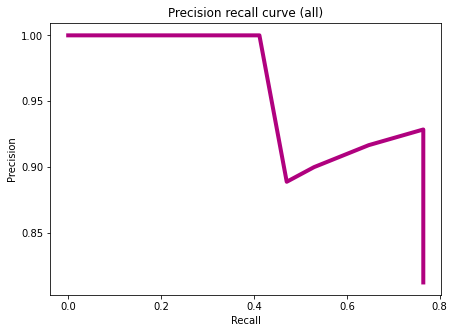

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(recall, precision, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.rcParams.update({'font.size': 16})
    
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

**Discussion Question**: Among all the threshold values tried, what is the **smallest** threshold value that achieves a precision of 96.5% or better? Round your answer to 3 decimal places.

In [71]:
for idx, precision in enumerate(precision_all):
    if precision >= 0.965:
        print(threshold_values[idx])
        break

0.5555555555555556


**Discussion Question**: Using `threshold` = 0.98, how many **false negatives** do we get on the **test_data**? (**Hint**: You may use the Sklearn precision and recall functions.)

In [72]:
predictions = apply_threshold(probabilities, 0.98)
cm = confusion_matrix(y_test, predictions)
cm[1][0]

17

This is the number of false negatives (i.e the number of reviews to look at when not needed) that we have to deal with using this classifier.

# Evaluating specific search terms

So far, we looked at the number of false positives for the **entire test set**. In this section, let's select reviews using a specific search term and optimize the precision on these reviews only. After all, a manufacturer would be interested in tuning the false positive rate just for their products (the reviews they want to read) rather than that of the entire set of products on Amazon.

## Precision-Recall on all tv related items

From the **test set**, select all the reviews for all products with the word 'tv' in them.

In [73]:
tv_reviews = X_test_sentiment[X_test['reviews'].apply(lambda x: 'tv' in x.lower())]
tv_y = y_test[X_test['reviews'].apply(lambda x: 'tv' in x.lower())]

Now, let's predict the probability of classifying these reviews as positive:

In [74]:
probabilities = sentiment_model.predict_proba(tv_reviews)

Let's plot the precision-recall curve for the **tv_reviews** dataset.

**First**, let's consider the following `threshold_values` ranging from 0.5 to 1:

In [75]:
threshold_values = np.linspace(0.5, 1, num=100)

**Second**, as we did above, let's compute precision and recall for each value in `threshold_values` on the **tv_reviews** dataset.  Complete the code block below.

In [76]:
precision_all = []
recall_all = []

for threshold in threshold_values:    
    # Make predictions. Use the `apply_threshold` function 
    ## YOUR CODE HERE 
    predictions = apply_threshold(probabilities, threshold)

    # Calculate the precision.
    # YOUR CODE HERE
    precision = precision_score(tv_y, predictions, zero_division=1)
    
    # YOUR CODE HERE
    recall = recall_score(tv_y, predictions)
    
    # Append the precision and recall scores.
    precision_all.append(precision)
    recall_all.append(recall)

**Discussion Question**: Among all the threshold values tried, what is the **smallest** threshold value that achieves a precision of 96.5% or better for the reviews of data in **products**? Round your answer to 3 decimal places.

In [77]:
for idx, precision in enumerate(precision_all):
    if precision >= 0.965:
        print(threshold_values[idx])
        break

0.5


**Discussion Question:** Is this threshold value smaller or larger than the threshold used for the entire dataset to achieve the same specified precision of 96.5%?

**Finally**, let's plot the precision recall curve.

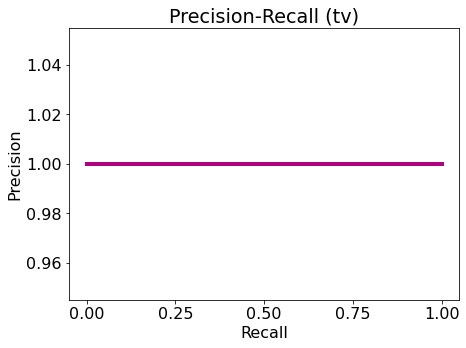

In [78]:
plot_pr_curve(precision_all, recall_all, "Precision-Recall (tv)")

What do you notice about the precision vs. recall values?